In [62]:
#Importaciones Necesarias
#setx CURL_SSL_NO_REVOKE 1
#setx CURL_SSL_NO_REVOKE ""

from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.coordinates import Angle
import astropy.units as u
import pandas as pd
import os
import shutil
import subprocess
from IPython.display import clear_output
import csv
from datetime import datetime
from astropy.time import Time
import matplotlib.pyplot as plt
from astroquery.mast import Tesscut
from scipy.signal import periodogram
import numpy as np
import requests
from concurrent.futures import ThreadPoolExecutor
from rich.progress import Progress, BarColumn, TextColumn, TimeRemainingColumn
from astropy.timeseries import LombScargle

In [10]:
#Se define la función que obtiene la info de Simbad
Gaia.ROW_LIMIT = -1 
Ra,Dec=0,0
tiempo=[]
magnitud=[]
sector_seleccionado=0
gaia_id=0
object_name="a"
checkpoint=0
def get_coordinates_from_name(name):
    simbad = Simbad()
    result = simbad.query_object(name)
    if result is not None:
        ra = result['ra'][0] 
        dec = result['dec'][0]
        ra_hms = Angle(ra, unit=u.deg).to_string(unit=u.hourangle, sep=':', precision=7)
        dec_dms = Angle(dec, unit=u.deg).to_string(unit=u.deg, sep=':', precision=6, alwayssign=True)
        global Ra
        global Dec 
        Dec = dec
        Ra = ra
        return ra, dec,ra_hms,dec_dms
    else:
        raise ValueError(f"No se encontraron coordenadas para el objeto {name}")
        
#Se define la función que toma las coordenadas y hace el query en gaia
def query_gaia(ra, dec, radius_arcmin=1):
    radius_deg = radius_arcmin / 60.0  # Conversión: 1 arcmin = 1/60 grados
    try:
        # Realizar la consulta en Gaia
        job = Gaia.launch_job_async(f"""
            SELECT  ra, dec,source_id
            FROM gaiadr2.gaia_source
            WHERE CONTAINS(POINT('ICRS', ra, dec), 
                           CIRCLE('ICRS', {ra}, {dec}, {radius_deg})) = 1
        """)
        results = job.get_results()
        return results
    except Exception as e:
        print("Error en la consulta:", e)
        return None
        
#Obtener el ID de gaia
def gaia_ids():
    Simbad.add_votable_fields("ids")
    result = Simbad.query_object(object_name)
    if result is not None:
        ids = result["ids"][0].split("|")
        for id_ in ids:
            if "Gaia DR2" in id_:
                global gaia_id
                gaia_id = int(id_.replace("Gaia DR2 ", ""))
                print(f"🔍 Gaia DR2 ID de {object_name}: {gaia_id}")        
    else:
        return f"No se encontró el objeto '{object_name}' en Simbad."

#Se define la función que guarda los archivos en el csv como catálogo
def obtener_catalogo():
    ra, dec,ra_hms,dec_dms= get_coordinates_from_name(object_name)
    print(f"Coordenadas de {object_name} - RA: {ra}°, DEC: {dec}°")
    print(f"Coordenadas de {object_name} - RA_HMS: {ra_hms}, DEC_DMS: {dec_dms}")
    
    results = query_gaia(ra, dec, radius_arcmin=radius_arcmin)
    
    print(f"Se hallaron {len(results)} objetos")
    print(f"✅ Catálogo descargado")
    data = results.to_pandas()
    data.to_csv(f'datos_gaia3edr.csv',index = False, header=False,sep=" ")
    rows, columns = data.shape
    

In [12]:
def Definir_sector():
    print(f"Para el objeto {object_name} se tienen los sectores:")
    sectors = Tesscut.get_sectors(objectname=object_name)
    print(f"\n{sectors}\n")
    global sector_seleccionado
    sector_seleccionado = input("Ingrese el sector a analizar:")
    catalogo_sector= f"tesscurl_sector_{sector_seleccionado}_ffic.sh"
    
    if catalogo_sector in os.listdir("."):
        print(f"✅ Archivo .sh del sector listo")
    else:
        print(f"El Archivo .sh del sector {sector_seleccionado} no se encuentra en la carpeta {os.path.basename(os.getcwd())}")
        url = f"https://archive.stsci.edu/missions/tess/download_scripts/sector/tesscurl_sector_{sector_seleccionado}_ffic.sh"
        print(f"Se procede a descargarlo...")
        carpeta_destino = os.getcwd() 
        nombre_archivo = f"tesscurl_sector_{sector_seleccionado}_ffic.sh"
        ruta_completa = os.path.join(carpeta_destino, nombre_archivo)
        response = requests.get(url)
        
        if response.status_code == 200:
            with open(ruta_completa, "wb") as file:
                file.write(response.content)
            print(f"✅ Archivo descargado en: {ruta_completa}")
        else:
            print(f"❌ Error")
    with open(f"tesscurl_sector_{sector_seleccionado}_ffic.sh", "rb") as archivo:  # Modo binario para mayor velocidad
        print(f"Es posible descargar {sum(1 for _ in archivo)} imágenes del sector {sector_seleccionado}")

In [14]:
#Comprobación del directorio de Trabajo, de fallar regersar a la carpeta principal
dest_dir ="./imagenes"
current_dir = os.getcwd()
current_folder = os.path.basename(current_dir)
if f'./{current_folder}' == dest_dir:
    print(f"Estás dentro de {current_folder}. Saliendo...")
    os.chdir("..") 
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

def verificar_archivo(archivo_fits, tamaño_esperado=17775360):
    """Devuelve True si el archivo existe y tiene el tamaño esperado, False si está corrupto o incompleto."""
    return os.path.exists(archivo_fits) and os.path.getsize(archivo_fits) >= tamaño_esperado

def descargar_imagen(linea, progress, task):
    """Descarga la imagen y actualiza la barra de progreso."""
    nombre_archivo = linea.split("/")[-1] if "http" in linea else None
    ruta_destino = os.path.join("./imagenes", nombre_archivo) if nombre_archivo else None

    proceso = subprocess.run(f"{linea} -o {ruta_destino}", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, cwd="./imagenes")

    progress.update(task, advance=1)  # ✅ La barra avanza en cada intento de descarga

    if verificar_archivo(ruta_destino):
        return None  # Descarga exitosa
    else:
        return nombre_archivo  # Devuelve el nombre si falló

def ejecutar_curl_desde_archivo(archivo_sh, linea_inicio, linea_final):
    """Ejecuta descargas en paralelo con barra de progreso y devuelve solo archivos que fallaron."""
    with open(archivo_sh, "r") as archivo:
        lineas = [linea.strip() for i, linea in enumerate(archivo) if linea_inicio <= i < linea_final]  # 🔹 `-1` se maneja con `<`

    max_workers = min(10, os.cpu_count())  # Limita las descargas simultáneas

    with Progress(
        TextColumn(f"[bold cyan][{linea_inicio} a {linea_final}]⏳Descargando..."),
        BarColumn(bar_width=25, style="white", complete_style="bright_cyan", finished_style="bright_cyan"),
        TextColumn("[bold cyan]{task.percentage:>3.0f}%"),
        TimeRemainingColumn(),
    ) as progress:
        task = progress.add_task("", total=len(lineas))  # ✅ Asegurar que total es correcto

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            errores = list(filter(None, executor.map(lambda l: descargar_imagen(l, progress, task), lineas)))
    clear_output(wait=True)
    return errores  # Devuelve solo los archivos que fallaron

            

In [16]:
#Se define la función principal, esta descarga imágenes y las analiza con phot3.py
def Descarga_y_analizis():
    global checkpoint
    print(f"Ultimo checkpoint: {checkpoint}")
    print("Seleccione el rango de imagenes a descargar; tenga en cuenta que cada una pesa ~34mb")
    inicio = int(input("Imagen de inicio"))
    porciclo =  int(input("Imagenes por ciclo"))
    ciclos = int(input(f"Cuantos ciclos de {porciclo} imagenes"))
    print(f"\nSe descargaran {porciclo} imagenes por ciclo, se necesitan ~{(porciclo)*34}mb cada vez")
    switch= input("continuar? [y/n]")
    if switch=="y":
        for i in range(ciclos):
            dest_dir ="./imagenes"
            current_dir = os.getcwd()
            current_folder = os.path.basename(current_dir)
            if f'./{current_folder}' == dest_dir:
                print(f"Estás dentro de {current_folder}. Saliendo...")
                os.chdir("..") 
            
            ejecutar_curl_desde_archivo(f"tesscurl_sector_{sector_seleccionado}_ffic.sh",inicio+i*porciclo, inicio+porciclo+porciclo*i)
            print(f"✅Descarga de las imagenes {inicio+i*porciclo} a la {inicio+porciclo+porciclo*i} Finalizada.")
            print(f"Se ha descargado en total {(i+1)*porciclo} de {porciclo*ciclos} seleccionadas\n")
            print("⏳Analizando las imagenes...")
            
            result = subprocess.run("python phot3.py", shell=True, capture_output=True, text=True)
            import re
            print(re.sub(r'\n+', '\n', result.stdout).strip())  # Reduce espacios en blanco
            
            print(result.stderr)
            
            shutil.rmtree("./imagenes")
            os.makedirs("./imagenes", exist_ok=True)
            print("\n✅Imagenes borradas de la carpeta imagenes, proceso finalizado ")
            checkpoint=inicio+porciclo*ciclos
            clear_output(wait=True)
            
    else:
        print(f"❌ Cancelado")

In [18]:
#Esto lo que hace es analizar los datos csv, y construir las dos listas con los datos a graficar
def conteo_datos():
    gaia_ids()
    nombre_carpeta = "csv_out"
    directorio = os.getcwd()
    directorio= os.path.basename(directorio)
    if not f'{directorio}' == nombre_carpeta:
        os.chdir("./csv_out")
    fechas=[]
    magnitudes=[]
    #Proceso de iteración
    for archivo in os.listdir("./"):
            with open(archivo, mode='r', newline='', encoding='utf-8') as archivo_csv:
                lector = csv.reader(archivo_csv)
                for fila in lector:
                    if fila[0] == str(gaia_id) : #Definir id de simbad del objeto
                        fechas.append(fila[5])
                        magnitudes.append(float(fila[3]))
    global tiempo
    global magnitud
    tiempo=fechas
    magnitud=magnitudes
    
    print(f"Datos agregados correctamente, actualmente se cuenta con {len(magnitudes)} datos")
    os.chdir("..")

In [20]:
#La gráfica no habria que mover nada aquí
def curvadeluz():
    global tiempo
    global magnitud
    
    fechas_clean = [Time(f, format='isot', scale='utc').jd for f in tiempo]
    fechas_clean_2 = [datetime.strptime(f, "%Y-%m-%dT%H:%M:%S.%f") for f in tiempo]
    
    flujos=[]
    for i in magnitud:
        flujos.append(10**(-i/2.5))
    
    plt.rcParams.update({
        'axes.facecolor': '#121212',  # Fondo del área del gráfico (gris oscuro)
        'figure.facecolor': '#121212',  # Fondo de la figura (gris oscuro)
        'font.family': 'Arial',  # Fuente
        'font.size': 10 ,  # Tamaño de la fuente
        'axes.labelcolor': 'white',  # Color de las etiquetas de los ejes (blanco)
        'xtick.color': 'white',  # Color de las etiquetas en el eje X (blanco)
        'ytick.color': 'white',  # Color de las etiquetas en el eje Y (blanco)
        'axes.edgecolor': 'white',  # Color de los bordes del gráfico (blanco)
        'grid.color': '#404040',  # Color de la cuadrícula (gris claro)
        'grid.linestyle': '--',  # Estilo de la cuadrícula (líneas discontinuas)
        'grid.alpha': 0.3,  # Transparencia de la cuadrícula (más suave)
        'lines.color': 'cyan',  # Color de las líneas (cian brillante)
        'lines.linewidth': 2,  # Ancho de las líneas
        'axes.titlecolor': 'white',  # Color del título de los ejes (blanco)
    })

    alto,ancho=4,8
    plt.figure(figsize=(ancho, alto))  
    plt.plot(fechas_clean[:], flujos[:], marker='o', linestyle='-', color="white",markerfacecolor='none', linewidth=1)
    plt.xlabel("Tiempo Juliano",fontsize=10,labelpad=20)
    plt.ylabel("Flujo",fontsize=10,labelpad=20) 
    plt.title(f"----------------Curva de luz para {object_name}----------------".upper(), fontsize=10,pad=10)
    
    plt.show()


In [64]:
def periodograma():
    fechas_clean = [Time(f, format='isot', scale='utc').jd for f in tiempo]
    flujos=[]
    for i in magnitud:
            flujos.append(10**(-i/2.5))
    time = np.array(fechas_clean) * u.day
    flux = np.array(flujos)        
    
    min_period = 0.1 * u.day  
    max_period = 10 * u.day  
    frequency = np.linspace(1/max_period, 1/min_period, 20000)  
    
    ls = LombScargle(time, flux)
    power = ls.power(frequency)
    
    best_frequency = frequency[np.argmax(power)]
    best_period = 1 / best_frequency
    print(f"Periodo más significativo: {best_period:.5f}")
    
    alto,ancho=4,8
    plt.figure(figsize=(ancho, alto))  
    plt.plot(1/frequency, power, marker='', linestyle='-', color="white",markerfacecolor='none', linewidth=1)
    plt.axvline(best_period.value, color="cyan", linestyle="--",linewidth=1)
    plt.xlabel("Periodo en dias",fontsize=10,labelpad=20)
    #plt.xscale("log")
    plt.ylabel("Potencia",fontsize=10,labelpad=20) 
    plt.title(f"----------Periodograma Lomb-Scargle de {object_name}----------".upper(), fontsize=10,pad=10)
    
    plt.show()

In [22]:
#Obtención del Catálogo
object_name = input("Ingresa el nombre del objeto: ")
radius_arcmin = float(input("Ingresa el radio de búsqueda en arcominutos: "))

Ingresa el nombre del objeto:  lambda tau
Ingresa el radio de búsqueda en arcominutos:  10


In [12]:
obtener_catalogo()

Coordenadas de lambda tau - RA: 60.1700698910475°, DEC: 12.49034444100722°
Coordenadas de lambda tau - RA_HMS: 4:00:40.8167739, DEC_DMS: +12:29:25.239988
INFO: Query finished. [astroquery.utils.tap.core]
Se hallaron 497 objetos
✅ Catálogo descargado


In [13]:
#os.chdir("./Taller 3")
os.getcwd()


'C:\\Users\\XC-1509\\Desktop\\Técnicas Observacionales\\Taller 3'

In [72]:
Definir_sector()

Para el objeto lambda tau se tienen los sectores:

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0005-1-4      5      1   4
tess-s0032-1-4     32      1   4
tess-s0042-4-3     42      4   3
tess-s0043-3-2     43      3   2
tess-s0044-1-1     44      1   1
tess-s0070-4-2     70      4   2
tess-s0071-2-4     71      2   4



Ingrese el sector a analizar: 5


✅ Archivo .sh del sector listo
Es posible descargar 19137 imágenes del sector 5


In [49]:
print(checkpoint)

12090


In [74]:
Descarga_y_analizis()

✅Descarga de las imagenes 12110 a la 12120 Finalizada.
Se ha descargado en total 30 de 30 seleccionadas

⏳Analizando las imagenes...
Su carpeta contiene 10 archivos .fits
No. 1: tess2018329055938-s0005-2-4-0125-s_ffic.fits
          ....            
No. 10: tess2018345172937-s0005-1-3-0125-s_ffic.fits
Error al procesar las coordenadas de 60.30560195352145, 12.503260255557: WCS should contain celestial component
Error al procesar las coordenadas de 60.30560195352145, 12.503260255557: WCS should contain celestial component
Se obtuvieron 0 archivos .csv


✅Imagenes borradas de la carpeta imagenes, proceso finalizado 


In [76]:
conteo_datos()

🔍 Gaia DR2 ID de lambda tau: 3305012316783145728
Datos agregados correctamente, actualmente se cuenta con 699 datos


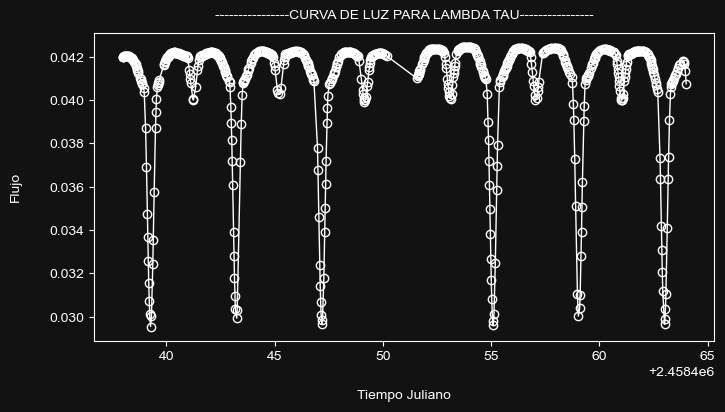

In [77]:
curvadeluz()

Periodo más significativo: 1.97660 d


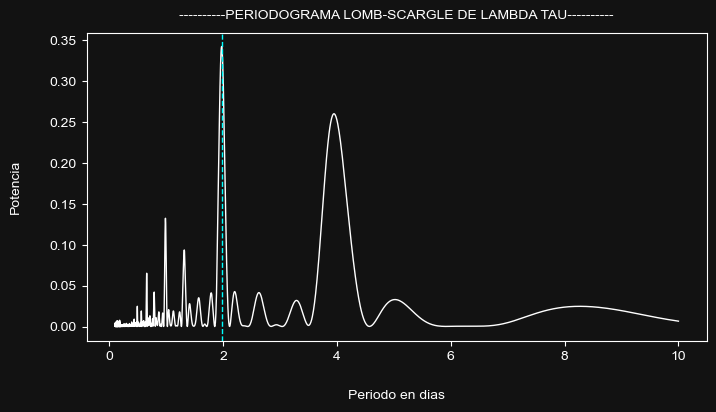

In [78]:
periodograma()